In [1]:
#importing required modules
import random
import sys
import copy


# Making the BEE class, used for creating the initial population of bees randomly

class Bee(object):
    """ Creates a bee object. """

    def __init__(self, dim, fun, funcon=None):
        
        """ Parameters-> fun    : evaluation function
                        funcon  : constraints functions, should return a boolean
                        dim     : the number of cities to be connected"""
        
        #creates the random solution vector for each bee
        self._random(dim)  
        
        #compute fitness of solution vector in terms of the distance covered
        if (fun != None):                                   
            self.value = fun(self.vector)
        else:
            self.value = sys.float_info.max
        self._fitness()
        
        #initialises the limit of the trial counter for the bee. This helps in determining when the bee is to be abandoned
        self.counter = 0                                    
    def _random(self, dim):
        """ Initialises the solution vector for the bee, randomly. """

        np.random.seed(1)
        self.vector = list(np.random.choice(range(dim),size=dim,replace=False))
        #for the TSP, starting and ending point has to be same
        self.vector = self.vector + [self.vector[0]]          
        #print (self.vector)
        
    def _fitness(self):
        """
        Calculates the fitness of the solution vector/Bee in terms of the Eucledian distance traversed from the initial point to the ending point.
        A bee will be considered fit if the distance traversed is the least.
        """
        self.fitness = 1/self.value

In [2]:
class BeeHive(object):
    """
    The Artificial Bee Colony (ABC) Algorithm.
    The bee population of the hive will have :
    1. employed bees
    2. onlooker bees
    3. scout bees """

    def run(self):
        """ Function running the Artificial Bee Colony (ABC) algorithm. """

        cost = {}; cost["best"] = []; cost["mean"] = []
        #restricting number of iterations to the number of locations in TSP
        for itr in range(self.dim-3):                  
            self.fix_best_index(itr)  
            '''
            Fixing the respective indices of each bee as in the best solution
            for 0th iteration, the 0th index is fixed of all the bees and mutation will be done from 1 to 2nd last position
            this will be continued till the 2nd last position is fixed before mutation
            
            '''
            
            # employees phase: each bee will be sent for mutation; size = number of bees taken
            for index in range(self.size):
                self.send_employee(index, itr)
                          
                    
            # onlookers phase 
            self.send_onlookers(itr)
 
            # scouts phase: in each iteration bees are checked for their number of trials and are abandoned if trial exceeds the maximum limit
            self.send_scout(itr)

            # computes best path: at the end of each iteration, best bee is found out of all the bees
            self.find_best()

            # stores convergence information: for storing the information about the best solution in each iteration
            cost["best"].append( self.best )
            cost["mean"].append( sum( [ bee.value for bee in self.population ] ) / self.size )

            # prints out information about computation
            if self.verbose:
                self._verbose(itr, cost)
                
            
        return cost

    def __init__(self                 ,
                 dim                  ,
                 fun          = None  ,
                 numb_bees    = 50    ,
                 max_itrs     = 50    ,
                 max_trials   = None  ,
                 selfun       = None  ,
                 seed         = None  ,
                 verbose      = False ,
                 extra_params = None ,):
        """
        Instantiates a bee hive object.
        Initialisation Phase:
        Parameters-> dim          :  number of cities in the TSP
                     fun          :  evaluation function (cost function)
                     numb_bees    :  number of bees within the hive
                     max_itrs     :  maximum number of iterations in each run
                     max_trials   :  limit for the trails of each bee before abandonment
                     self_fun     :  custom selection function
                     seed         :  seed of random number generator
                     verbose      :  makes computation verbose
                     extra_params :  optional extra arguments for selection function selfun
        """

        # generates a seed for the random number generator
        if (seed == None):
            self.seed = random.randint(0, 1000)
        else:
            self.seed = seed
        random.seed(self.seed)

        # computes the number of employees, making sure it's even
        self.size = int((numb_bees + numb_bees % 2))

        # the properties of algorithm are assigned 
        self.dim = dim
        self.max_itrs = max_itrs
        if (max_trials == None):
            self.max_trials = 0.6 * self.size * self.dim
        else:
            self.max_trials = max_trials
        self.selfun = selfun
        self.extra_params = extra_params

        # assigns properties of the optimisation problem
        self.evaluate = fun
        #initial best value is generated
        self.best = sys.float_info.max                  
        print("initial best cost is", self.best)
        self.solution = None

        #bee hive for the total number of bees is populated
        self.population = [ Bee(dim, fun) for i in range(self.size) ]

        # initialises best solution vector to food nectar
        self.find_best()
        
        # computes selection probability
        self.compute_probability()

        # verbosity of computation
        self.verbose = verbose
        

    def find_best(self):
        """ Finds current best bee candidate. """

        values = [ bee.value for bee in self.population ]
        index  = values.index(min(values))
        if (values[index] < self.best):
            self.best     = values[index]
            self.solution = self.population[index].vector
            
    def compute_probability(self):
        """
        After the employed bees are back in the hive, they do the waggle dance.
        This function computes the probability of a bee's solution getting chosen by an onlooker bee
        
        """

        # finds the bee with the most fitness in the hive
        values = [bee.fitness for bee in self.population]
        max_values = max(values)

        # computing probalities as is done by Karaboga in his classic ABC implementation
        if (self.selfun == None):
            self.probas = [0.9 * v / max_values + 0.1 for v in values]
        else:
            if (self.extra_params != None):
                self.probas = self.selfun(list(values), **self.extra_params)
            else:
                self.probas = self.selfun(values)

        # returns intervals of probabilities
        return [sum(self.probas[:i+1]) for i in range(self.size)]

         
    def fix_best_index(self, fix_index):
        '''
        This function fixes the respective index in each bee as in the best bee found in the iteration
        '''
        
        best_index = fix_index
        for each_bee in self.population:
            each_bee.vector[best_index] = self.solution[best_index]
            #making sure that starting and ending point is same in the bee
            if  (best_index == 0):
                each_bee.vector[-1] = self.solution[best_index]
            
            #after fixing the index in each bee, their fitness is again calculated
            each_bee.value = self.evaluate(each_bee.vector)
            each_bee._fitness()    
        
        
    def send_employee(self, index, fixed_index):
        """ 
        SEND EMPLOYED BEES PHASE: during this phae, each bee is sent for mutation.
        If the mutated bee is better than the earlier bee vector, the new vector 
        is assigned to the bee.
        
        """   
        import numpy as np
        # deepcopies current bee solution vector
        zombee = copy.deepcopy(self.population[index])
        
        #starting mutation after the fixed position in the bee upto its end
        start_mutation_index = fixed_index + 1

        # picks up two positions in the bee to be swapped resulting in mutation
        d1,d2 = np.random.choice(range(start_mutation_index, self.dim-1), size = 2, replace = False)

        # produces a mutant bee
        zombee.vector = self._mutate(d1, d2, index)

        # computes fitness of mutant
        zombee.value = self.evaluate(zombee.vector)
        zombee._fitness()

        '''
        Deterministic crowding: checks if the new bee formed is better than the earlier one. 
        If not, previous bee's trials are incremented by 1
        '''
        if (zombee.fitness > self.population[index].fitness):
            self.population[index] = copy.deepcopy(zombee)
            self.population[index].counter = 0
        else:
            self.population[index].counter += 1

    def send_onlookers(self, fixed_idx):
        """
        SEND ONLOOKERS PHASE: onlooker bees try to locally improve the solution 
        path they decided to follow after the waggle dance. If improved, this is 
        communicated to the bee whose solution they chose after the "waggle dance."""

        # sends onlookers
        numb_onlookers = 0; beta = 0
        while (numb_onlookers < self.size):

            # draws a random number from U[0,1]
            phi = random.random()

            # increments roulette wheel parameter beta
            beta += phi * max(self.probas)
            beta %= max(self.probas)

            # selects a new onlooker based on waggle dance
            index = self.select(beta)

            # sends new onlooker
            self.send_employee(index, fixed_idx)

            # increments number of onlookers
            numb_onlookers += 1

    def select(self, beta):
        """
        Waggle Dance Phase: onlooker bees are selected using a roulette wheel selection

        Parameters-> beta  : "roulette wheel selection" parameter - i.e. 0 <= beta <= max(probas)

        """
        # computes probability intervals "online" - i.e. re-computed after each onlooker
        probas = self.compute_probability()

        # selects a new potential "onlooker" bee
        for index in range(self.size):
            if (beta < probas[index]):
                return index

    def send_scout(self, fixed_position):
        """
        SCOUT BEE PHASE: bee for which its trials exceeds the maximum limit of trials for any bee, is abandoned and 
        new bee is created instead. Thus, it becomes a scout bee, reventing the stagnation of employed bee population.
        This eliminates any local optima. 
        """        
       
        # retrieves the number of trials for all bees
        trials = [ self.population[i].counter for i in range(self.size) ]

        # identifies the bee with the greatest number of trials
        index = trials.index(max(trials))

        # checks if its number of trials exceeds the pre-set maximum number of trials
        if (trials[index] > self.max_trials):
            
            # creates a new scout bee randomly
            self.population[index] = Bee(self.dim, self.evaluate)
            print(len(self.population[index].vector))
            
            '''
            The new bee created needs to have the same fixed positions as are in other bees,
            before its further mutated. Thus, picking some other bee and fixing the indices in this new bee
            
            '''
            
            other_index_bee = index 
            while (other_index_bee == index): other_index_bee = random.randint(0, self.size-1)
        
            #fixing the part from starting till the point, where every other bee's part is fixed
            second_bee = self.population[other_index_bee]
           
            fix_part = second_bee.vector[:fixed_position+1]         
            for fix in fix_part:
                if (fix in self.population[index].vector):
                    self.population[index].vector.remove(fix)
                    
            self.population[index].vector = fix_part + self.population[index].vector
            
            self.population[index].vector[-1] = self.population[index].vector[0]
            
            # sends scout bee to exploit its solution vector by mutating itself
            self.send_employee(index, fixed_position)

    def _mutate(self, position1, position2, current_bee):
        """
        
        Mutates the bee vector: 
        Parameters-> position1   : 1st position in the bee vector to be mutated
                     position 2  : 2nd position in the bee to be mutated
                     current_bee : Bee vector to be mutated
        """
        current_bee_vector = self.population[current_bee].vector
        
        mutated_part = current_bee_vector[min(position1,position2):max(position1,position2)+1]
        mutated_part.reverse()
        current_bee_vector[min(position1,position2):max(position1,position2)+1] = mutated_part
        #because mutation is being done till 2nd last position, the last position will remain untouched, therefore, commented the above part

        return current_bee_vector
                
        
    def _verbose(self, itr, cost):
        """ Displays information about computation. """

        msg = "# Iter = {} | Best Evaluation Value = {} | Mean Evaluation Value = {} "
        print(msg.format(int(itr), cost["best"][itr], cost["mean"][itr]))

# ---- END

In [3]:
#!/usr/bin/env python

# ---- MODULE DOCSTRING

#__doc__ = """


# ---- IMPORT MODULES

try:
    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
except:
    raise ImportError("Install 'matplotlib' to plot convergence results.")

# ---- CONVERGENCE PLOT

def ConvergencePlot(cost):
    """
    Plots the convergence plot of the best cost
    Parameters-> cost: mean and best cost in each iteration 
    
    """
    %matplotlib inline
    import matplotlib.pyplot as plt
    font = FontProperties();
    font.set_size('larger');                              
    labels = ["Best Cost Function", "Mean Cost Function"]
    plt.figure(figsize=(12.5, 4));
    plt.plot(range(len(cost["best"])), cost["best"], label=labels[0]);
    plt.scatter(range(len(cost["mean"])), cost["mean"], color='red', label=labels[1]);
    plt.xlabel("Iteration #");
    plt.ylabel("Value [-]");
    plt.legend(loc="best", prop = font);
    plt.xlim([0,len(cost["mean"])]);
    plt.grid();
    plt.show();

# ---- END

COST FUNCTION: Calculated as a function of the Euclidian Distance traversed from the starting city to the final city and back to the starting city 

         
$$
D=\sum_{i=0}^{N-2}\sqrt{(x_i-x_{i+1})^2+(y_i-y_{i+1})^2}+\sqrt{(x_{N-1}-x_{0})^2+(y_{N-1}-y_{0})^2}
$$

$\sum_{i=0}^{N-2}\sqrt{(x_i-x_{i+1})^2+(y_i-y_{i+1})^2}$: the total distance from $[C_0,...,C_{N-1}]$

$\sqrt{(x_{N-1}-x_{0})^2+(y_{N-1}-y_{0})^2}$: the distance from $C_{N-1}$ to $C_0$ (where the salesman started)

D: total distance of the path

For run number 1
initial best cost is 1.7976931348623157e+308


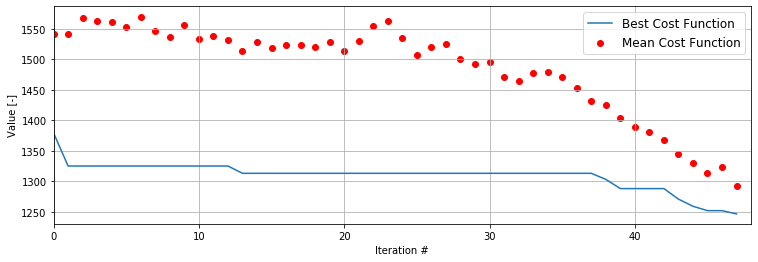

Fitness Value ABC: 1246.5056464609988
Bee Hive done! Time elapsed: 65.57172083854675 seconds
For run number 2
initial best cost is 1.7976931348623157e+308


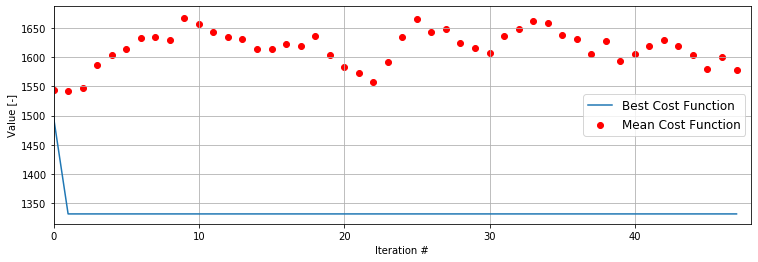

Fitness Value ABC: 1332.1859893649485
Bee Hive done! Time elapsed: 65.68977689743042 seconds


In [6]:
#!/usr/bin/env python

# ---- MODULE DOCSTRING

#__doc__ = """



# ---- IMPORT MODULES

try:
    import numpy as np
except:
    raise ImportError("Numpy module not installed.")

# ---- CREATE TEST CASE

def evaluator(vector):
 
    #vector = np.array(vector)
    import pandas as pd
    dataframe_locations = pd.DataFrame()
    dataframe_locations['x'] = [27,30,43,58,58,37,38,46,61,62,63,32,45,59,5,10,21,5,30,39,32,25,25,48,56,30,37,49,52,20,40,21,17,31,52,51,42,31,5,12,36,52,27,17,13,57,62,42,16,8,7]
    dataframe_locations['y'] = [68,48,67,48,27,69,46,10,33,63,69,22,35,15,6,17,10,64,15,10,39,32,55,28,37,40,52,49,64,26,30,47,63,62,33,21,41,32,25,42,16,41,23,33,13,58,42,57,57,52,38]
    
    
    distance_sum = 0
    size_locations = dataframe_locations.shape[0]
    #calculating the Eucledian distance 
    
    for idx in range(0,size_locations-1):
        distance_sum += np.sqrt((dataframe_locations.loc[vector[idx],'x'] - dataframe_locations.loc[vector[idx+1],'x'])**2+(dataframe_locations.loc[vector[idx],'y']-dataframe_locations.loc[vector[idx+1],'y'])**2)
    distance_sum += np.sqrt((dataframe_locations.loc[vector[-1],'x']-dataframe_locations.loc[vector[0],'x'])**2+(dataframe_locations.loc[vector[-1],'y']-dataframe_locations.loc[vector[0],'y'])**2)

    return distance_sum


# ---- SOLVE TEST CASE WITH ARTIFICIAL BEE COLONY ALGORITHM

def run():

  
    import time
    for run in range(1,11):
        print("For run number", run)
        model = BeeHive(dim           = 51,
                        fun           = evaluator,
                        numb_bees     =  50,
                        max_itrs      =  50,)
        #number of bees can be changed here to see for results with different number of bees
        time_start = time.time() #to calculate the time of execution
        
        # runs model
        cost = model.run()
        
        # plots convergence
        ConvergencePlot(cost)
        
        # prints out best solution
        
        print("Fitness Value ABC: {0}".format(model.best))
        print ('Bee Hive done! Time elapsed: {} seconds'.format(time.time()-time_start))

    
    
        
if __name__ == "__main__":
    run()


# ---- END
